In [65]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import xarray as xr
import glob
import copy
from pathlib import Path
import dask 
from os.path import join,expanduser
import sys
import time as time
import xskillscore as xs
from statsmodels.tsa.seasonal import STL
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches 
import cartopy as cart
import cartopy.crs as ccrs

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

notebook_path = os.getcwd()

In [3]:
def ano(var):
    # calculate annual mean anomalies of a time series
    return var-var.mean()

def mon_ano(var):
    # calculate monthly anomalies of a time series
    return var.groupby('time.month') - var.groupby('time.month').mean('time')
    
def anu(var):
    # To calculate annual means from monthly data
    return var.groupby('time.year').mean('time')
    
def delta(var):
    # To calculate linear trend and associated Pearson R p-value of input variables
    # var: annual means with other spatial dimensions, xarray.DataArray
    # Return :
    #    trd: Linear trend per year
    #    p: p-values
    years = var.year
    trd = xs.linslope(years,var,dim='year')
    p = xs.pearson_r_p_value(years,var,dim='year')
    return trd, p 

def detrend(var):
    # To detrend annual mean data
    slope, intercept = var.polyfit(dim='year',deg=1).polyfit_coefficients[0:2]
    t = var.year
    var_regressed = slope*t + intercept
    if (len(var.dims)==1):
        return var - var_regressed.values  
    elif (len(var.dims)==2):
        return var - var_regressed.transpose('year', 'lat').values  
    elif (len(var.dims)==4):
        return var - var_regressed.transpose('year', 'tile', 'j', 'i').values 
    else:
        print('Check the dimension!')

ds = xr.open_dataset('./clean_datasets/ECCOv4r5_AMOC_stf_3D_199201-201912.nc').load()

## Climatology and trend 
psi_moc_clm = ds['psi_moc'].mean('time')
psl_anu = anu(ds['psi_moc'])
psi_moc_ann_trd, psi_moc_ann_trd_pvalue = delta(psl_anu)

moc_anu = anu(ds['moc']) 
moc_anu_dt = detrend(moc_anu) # detrended MOC


In [45]:
f = xr.open_dataset('/efs_ecco/czimmerm/moc_sig2_time_mean.nc')
moc_sig2 = f['psi']
f = xr.open_dataset('/efs_ecco/czimmerm/moc_sig2_01-2008_12-2010.nc')
moc_sig2_2010 = f['psi'][-12:,:,:].mean('time')
moc_sig2_2010

<xarray.DataArray 'psi' (sig2: 50, lat: 110)> Size: 44kB
array([[ 715788.33333333,  720294.16666667,  726465.33333333, ...,
        2973068.        , 2936959.91666667, 2935001.        ],
       [ 715788.33333333,  720294.16666667,  726465.33333333, ...,
        2973068.        , 2936959.91666667, 2935001.        ],
       [ 715788.33333333,  720294.16666667,  726465.33333333, ...,
        2973068.        , 2936959.91666667, 2935001.        ],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])
Coordinates:
  * sig2        (sig2) int32 200B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * lat         (lat) int64 880B -30 -29 -28 -27 -26 -25 ... 74 75 76 77 78 79
    SIGMA_levs  (sig2) float64 400B ...

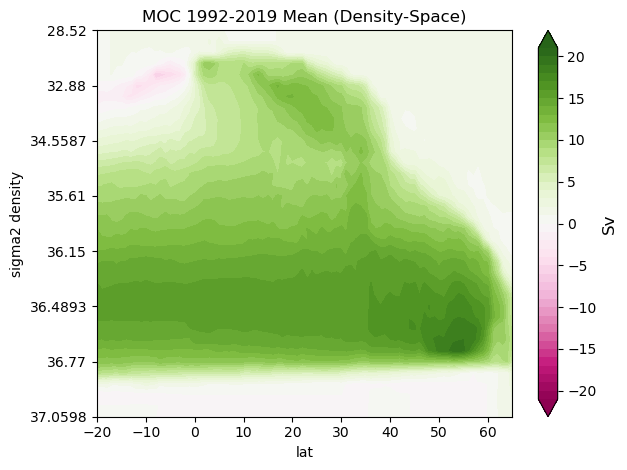

In [38]:
cs = plt.contourf(moc_sig2.lat,np.arange(0,50), moc_sig2/1e6, cmap='PiYG',levels=np.arange(-21,22,1),extend='both')
cb = plt.colorbar(cs)
cb.set_label('Sv',fontsize=12)
plt.ylabel('sigma2 density')
plt.xlabel('lat')
plt.yticks(np.arange(0,50)[::5], f.SIGMA_levs.values[::5])
plt.ylim(35,0)
plt.xlim(-20,65)
plt.title('MOC 1992-2019 Mean (Density-Space)')
plt.tight_layout()
plt.savefig('./plots/MOC_mean_sigma2.png',dpi=800)

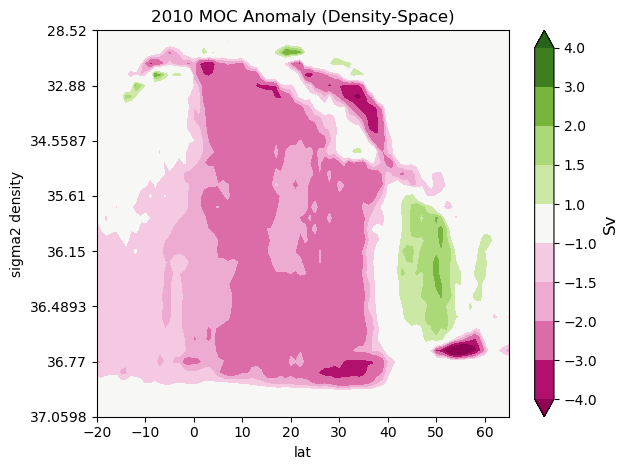

In [82]:
cs = plt.contourf(moc_sig2.lat,np.arange(0,50), (moc_sig2_2010-moc_sig2)/1e6, cmap='PiYG',
                  levels=np.array([-4, -3, -2, -1.5, -1, 1, 1.5, 2, 3, 4]),extend='both')
cb = plt.colorbar(cs)
cb.set_label('Sv',fontsize=12)
plt.ylabel('sigma2 density')
plt.xlabel('lat')
plt.yticks(np.arange(0,50)[::5], f.SIGMA_levs.values[::5])
plt.ylim(35,0)
plt.xlim(-20,65)
plt.title('2010 MOC Anomaly (Density-Space)')
plt.tight_layout()
plt.savefig('./plots/MOC_2010_sigma2.png',dpi=800)

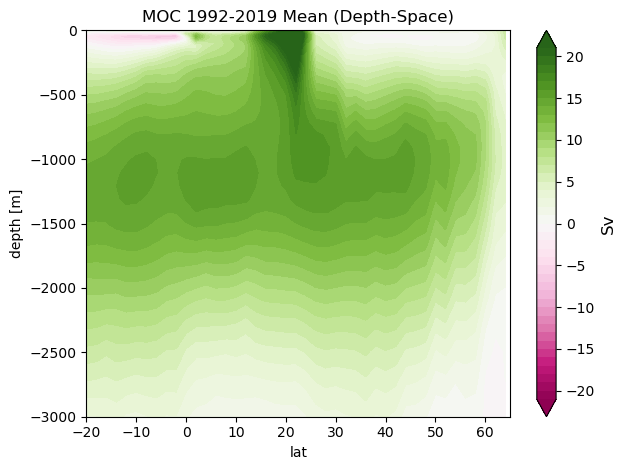

In [58]:
#psi_moc_clm.plot()
cs = plt.contourf(psi_moc_clm.lat,psi_moc_clm.Z, psi_moc_clm, cmap='PiYG',levels=np.arange(-21,22,1),extend='both')
cb = plt.colorbar(cs)
cb.set_label('Sv',fontsize=12)
plt.ylim(-3000,0)
plt.ylabel('depth [m]')
plt.xlabel('lat')
plt.xlim(-20,65)
plt.title('MOC 1992-2019 Mean (Depth-Space)')
plt.tight_layout()
plt.savefig('./plots/MOC_mean_depth.png',dpi=800)

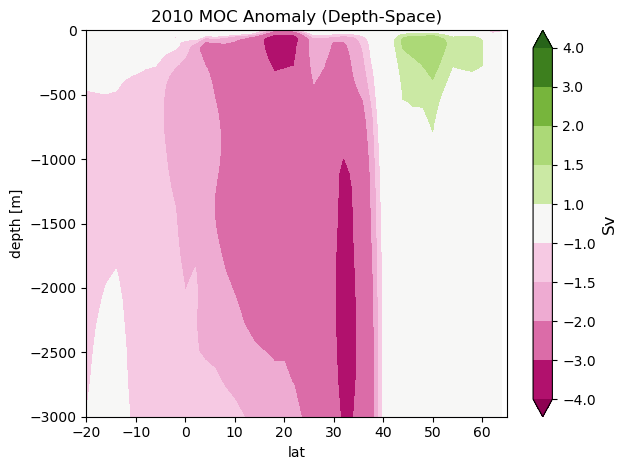

In [81]:
cs = plt.contourf(psi_moc_clm.lat,psi_moc_clm.Z, psl_anu.sel(year=2010)-psi_moc_clm, cmap='PiYG',
                  levels=np.array([-4, -3, -2, -1.5, -1, 1, 1.5, 2, 3, 4]),extend='both')
cb = plt.colorbar(cs)
cb.set_label('Sv',fontsize=12)
plt.ylim(-3000,0)
plt.ylabel('depth [m]')
plt.xlabel('lat')
plt.xlim(-20,65)
plt.title('2010 MOC Anomaly (Depth-Space)')
plt.tight_layout()
plt.savefig('./plots/MOC_2010_depth.png',dpi=800)

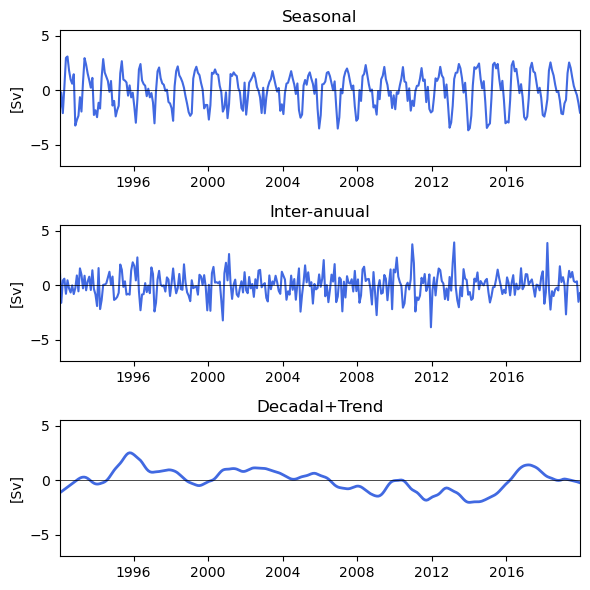

In [93]:
# Plot seasonal, decadal, trend, sub-decadal components
sel_lat = 54
moc_ano = ano(ds['moc'].sel(lat=sel_lat))
stl = STL(moc_ano, period=12)
result = stl.fit()
seasonal = result.seasonal
decadal_trd = result.trend
annul = result.resid

fig, axs = plt.subplots(3,1, figsize=(6,6))
axs[0].plot(ds['moc'].time, seasonal, c='royalblue')
axs[1].plot(ds['moc'].time, annul, c='royalblue')
axs[2].plot(ds['moc'].time, decadal_trd, c='royalblue',lw=2)
titles = ['Seasonal','Inter-anuual','Decadal+Trend']
for i in range(3):
    #axs[i].axvspan(ds['moc'].time.values[216], ds['moc'].time.values[228], fc='silver',alpha=0.5)
    axs[i].axhline(y=0,lw=0.5,c='k')
    axs[i].set_title(titles[i],loc='center')
    axs[i].set_xlim(ds['moc'].time[0],ds['moc'].time[-1])
    axs[i].set_ylabel('[Sv]')
    axs[i].set_ylim(-7,5.5)
plt.tight_layout()
plt.savefig('./plots/AMOC@'+str(sel_lat)+'_decomposed_anomaly_variability.png',dpi=1000)
plt.show()

# MHT

In [60]:
MHT = {}
variance = {}
mht_trd = {}
mht_amoc_cor = {}

In [62]:
sel_lats = [-20,-10,0,10,20,30,40,50]#
for sel_lat in sel_lats:
    MHT[sel_lat] = xr.open_dataset('./clean_datasets/ECCOv4r5_MHTat'+str(sel_lat)+'_199201-201912.nc')['MHT']
    # variance of detrended annual means 
    mht_trd[sel_lat] = delta(anu(MHT[sel_lat]))[0].values
    variance[sel_lat] = detrend(anu(MHT[sel_lat])).var('year').values
    print(sel_lat, variance[sel_lat],mht_trd[sel_lat]*10)
    #anu(MHT[sel_lat]).plot(label=str(sel_lat))
#plt.legend()
#plt.savefig('./MHT.png',dpi=1000)

-20 0.002740266074582947 -0.01232210680083839
-10 0.002763773781049602 -0.020872006515321354
0 0.0035571233141493547 -0.030004839161239288
10 0.007529086002240655 -0.029506898764602642
20 0.003061801712389188 -0.02625127941177563
30 0.003596197521496907 -0.029829063138141067
40 0.0019203843515386437 -0.02993206971770042
50 0.0013230605408874683 -0.03139431003040451


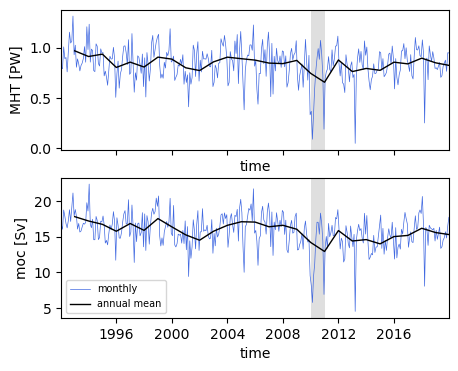

In [31]:
sel_lat = 30
fig, axs = plt.subplots(2,1,figsize=(5,4),sharex=True)
MHT[sel_lat].plot(ax=axs[0],c='royalblue',lw=0.5)
MHT[sel_lat].resample(time='1Y').mean().plot(ax=axs[0], c='k',lw=1)
ds['moc'].sel(lat=sel_lat).plot(ax=axs[1],c='royalblue',lw=0.5, label='monthly')
ds['moc'].sel(lat=sel_lat).resample(time='1Y').mean().plot(ax=axs[1], c='k',lw=1, label='annual mean')
axs[1].legend(fontsize=7)
n_month = 216 # 2010.1
for ax in axs:
    ax.set_title('',loc='center')
    #ax.axvline(x=MHT[sel_lat].time[n_month].values,ls='--',c='k')
    ax.axvspan(MHT[sel_lat].time[n_month].values, MHT[sel_lat].time[n_month+12].values, fc='silver',alpha=0.5)
    ax.set_xlim(MHT[sel_lat].time[0], MHT[sel_lat].time[-1])
    ax.set_xlabel('time')
plt.savefig('./plots/MHT&AMOCat30N.png',dpi=1000)

-20 0.917076031777528
-10 0.8803591144216892
0 0.7799100253341842
10 0.8439953123294848
20 0.6009595821692125
26 0.8780451677063059
30 0.9007306224552696
40 0.8720892752337553
50 0.8122653292046287


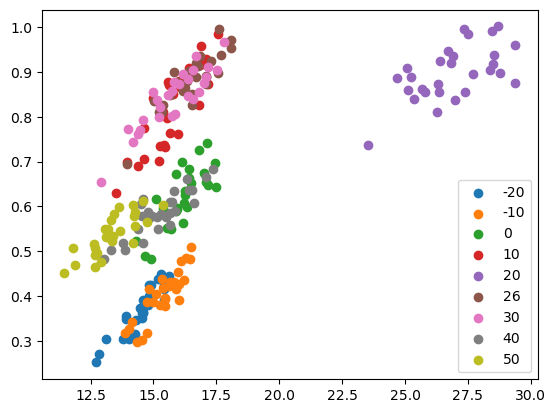

In [106]:
for sel_lat in sel_lats:
    mht_amoc_cor[sel_lat] = xs.pearson_r(moc_anu.sel(lat=sel_lat), anu(MHT[sel_lat]),dim='year').values
    plt.scatter(moc_anu.sel(lat=sel_lat),anu(MHT[sel_lat]),label=sel_lat)
    print(sel_lat, mht_amoc_cor[sel_lat])
plt.legend()

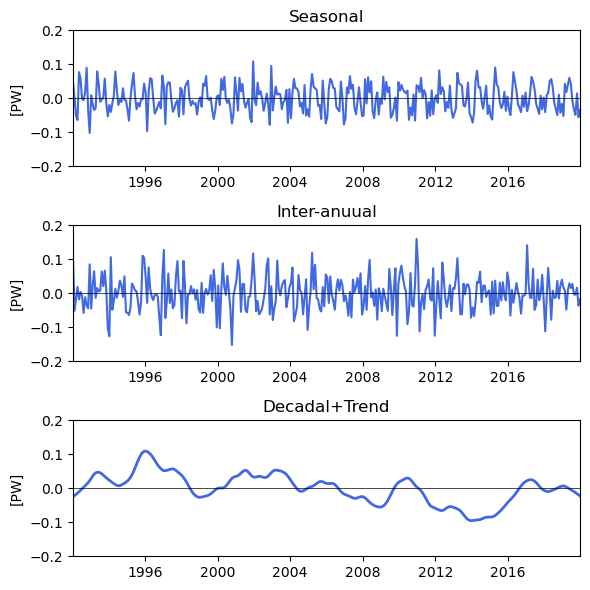

In [64]:
sel_lat = 50
mht_ano = ano(MHT[sel_lat])
stl = STL(mht_ano, period=12)
result = stl.fit()
seasonal = result.seasonal
decadal_trd = result.trend
annul = result.resid

fig, axs = plt.subplots(3,1, figsize=(6,6))
axs[0].plot(mht_ano.time, seasonal, c='royalblue')
axs[1].plot(mht_ano.time, annul, c='royalblue')
axs[2].plot(mht_ano.time, decadal_trd, c='royalblue',lw=2)
titles = ['Seasonal','Inter-anuual','Decadal+Trend']
for i in range(3):
    #axs[i].axvspan(mht_ano.time.values[216], mht_ano.time.values[228], fc='silver',alpha=0.5)
    axs[i].axhline(y=0,lw=0.5,c='k')
    axs[i].set_title(titles[i],loc='center')
    axs[i].set_xlim(mht_ano.time[0],mht_ano.time[-1])
    axs[i].set_ylabel('[PW]')
    axs[i].set_ylim(-.2,.2)
plt.tight_layout()
plt.savefig('./plots/MHT@'+str(sel_lat)+'_decomposed_anomaly_variability.png',dpi=1000)
plt.show()

In [ ]:
### Plot MOC time series at selective latitudes and compare with observations
total_transport_26 = (ds['trsp_z'].sel(lat=26)).cumsum('k').max('k') # -> yield the total northward transport in the upper branch 
# read in RAPID MOC
rapid = xr.open_dataset('./data/RAPID_MOC_Transports_202501.nc')
rapid

(<xarray.DataArray ()> Size: 8B
array(-0.07536684)
Coordinates:
    lat      int64 8B 26, <xarray.DataArray ()> Size: 8B
array(0.0001862)
Coordinates:
    lat      int64 8B 26)


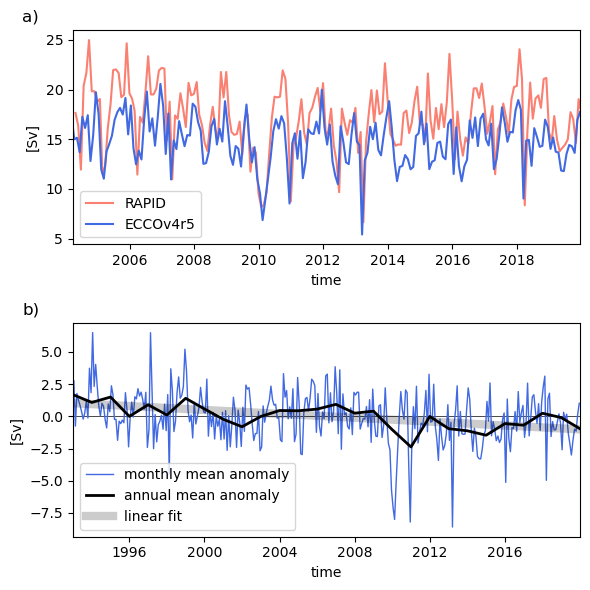

In [154]:
fig, axs =  plt.subplots(2, 1, figsize=(6,6), constrained_layout=True)

# plot monthly means 
rapid['moc_mar_hc10'].resample(time='1M').mean().plot(ax=axs[0],label='RAPID',c='salmon')
total_transport_26.plot(ax=axs[0],label='ECCOv4r5',c='royalblue')
axs[0].set_xlim(rapid['moc_mar_hc10'].time[0],total_transport_26['time'][-1])
axs[0].set_title('a)', loc='left',x=-0.1)
axs[0].set_title('', loc='center')
axs[0].legend(loc='lower left')

axs[1].axhline(y=0,lw=0.5,c='k')
mon_ano(total_transport_26).plot(ax=axs[1],label='monthly mean anomaly',c='royalblue',lw=1)
ano(total_transport_26.resample(time='1Y').mean()).plot(ax=axs[1],label='annual mean anomaly',c='k',lw=2)
time = total_transport_26.resample(time='1Y').mean().time
years = anu(total_transport_26).year.values
slope, intercept = ano(anu(total_transport_26)).polyfit(dim='year',deg=1).polyfit_coefficients[0:2].values
print(delta( anu(total_transport_26)))
axs[1].plot(time,slope*years+intercept,c='k',lw=6, alpha=0.2,label='linear fit')
axs[1].legend(loc='lower left')
axs[1].set_title('b)', loc='left',x=-0.1)
axs[1].set_title('', loc='center')
axs[1].set_xlim(time[0],time[-1])

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('[Sv]')
plt.tight_layout()
plt.savefig('./plots/MOC26&RAPID.png',dpi=1000)
plt.show()

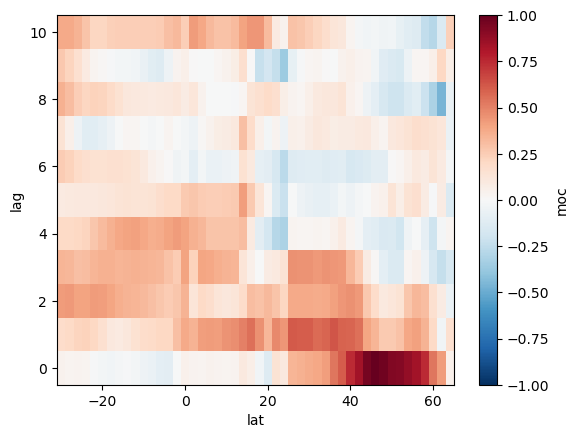

In [4]:
lags = np.arange(0,11,1)
temp = xs.pearson_r(moc_anu.sel(lat=46), moc_anu, dim='year')
r_crosslat = temp.expand_dims({"lag": lags},axis=0).copy()
for i in range(len(lags)):
    r_crosslat[i,:] = xs.pearson_r(moc_anu.sel(lat=46).shift(year=lags[i]), moc_anu, dim='year',skipna=True)
r_crosslat.plot() 

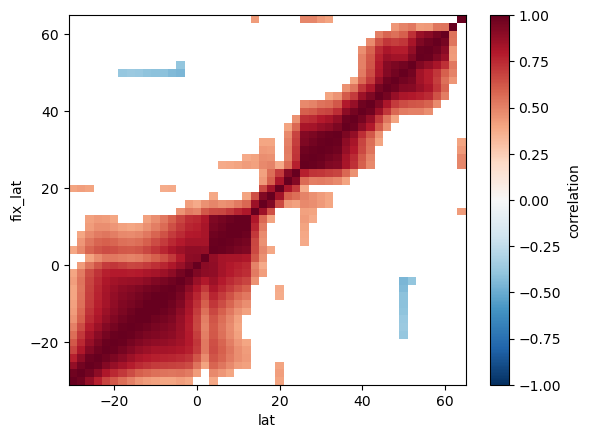

In [5]:
lats = temp.lat.values
coherence_nolag = temp.expand_dims({"fix_lat": lats},axis=0).copy().rename('correlation')
coherence_nolag_p = coherence_nolag.copy()
for i in range(len(lats)):
    coherence_nolag[i,:] = xs.pearson_r(moc_anu_dt.sel(lat=lats[i]), moc_anu_dt, dim='year')
    coherence_nolag_p[i,:] = xs.pearson_r_p_value(moc_anu_dt.sel(lat=lats[i]), moc_anu_dt, dim='year')
coherence_nolag.where(coherence_nolag_p<0.05).plot(cmap='RdBu_r')

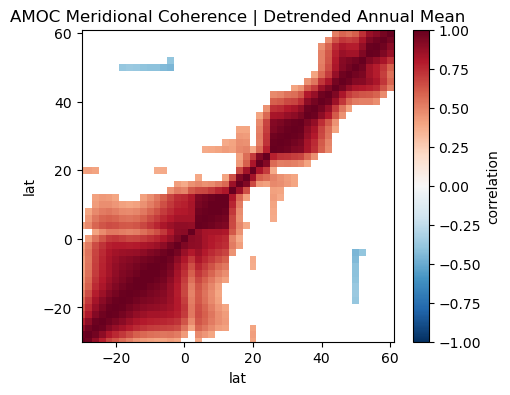

In [6]:
fig, ax =  plt.subplots(1, 1, figsize=(6,4), constrained_layout=False, sharex=True)
plt.subplots_adjust(top=0.9,bottom=0.12,left=0.15,right=0.8)
coherence_nolag.where(coherence_nolag_p<0.05).plot(cmap='RdBu_r')
plt.xlim(-30,61)
plt.ylim(-30,61)
plt.ylabel('lat')
plt.title('AMOC Meridional Coherence | Detrended Annual Mean')
plt.savefig('./plots/AMOC_mrdn_correlation_detrended.png',dpi=1000)

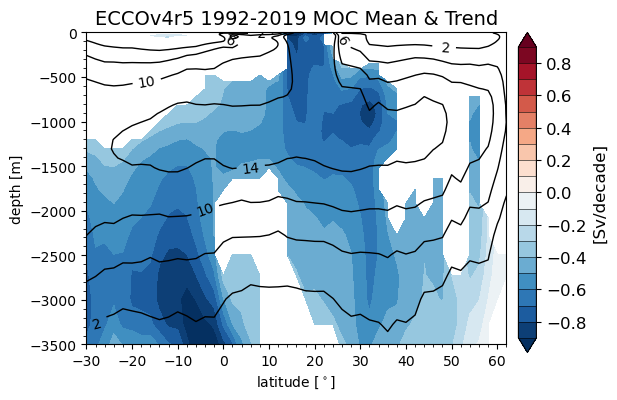

In [113]:
alpha = 0.05 # significance level for trends

fig, ax =  plt.subplots(1, 1, figsize=(6,4), constrained_layout=False, sharex=True)
plt.subplots_adjust(top=0.9,bottom=0.12,left=0.1,right=0.8)
clevs = np.arange(-2.8,3.2,0.4)
y_minor_locator=MultipleLocator(100)
y_major_locator=MultipleLocator(500)
x_minor_locator=MultipleLocator(2)
x_major_locator=MultipleLocator(10)
ax.set_title('ECCOv4r5 1992-2019 MOC Mean & Trend',loc='center',fontsize=14)

# Plot trends (shading)
psi_moc_ann_trd_sig = psi_moc_ann_trd.where(psi_moc_ann_trd_pvalue<alpha) # on;y plot significant trends
cs = ax.contourf(ds['lat'], ds['Z'], psi_moc_ann_trd_sig*10,levels=np.arange(-0.9,1,0.1),extend='both',cmap='RdBu_r')
#ax.contourf(ds['lat'], ds['Z'], psi_moc_ann_trd_pvalue, levels=[0,alpha,1], hatches=['\\\\',None],colors='none')
cbar_ax=fig.add_axes([0.82,0.1,0.03,0.8])
cb=plt.colorbar(cs,cax=cbar_ax,drawedges=1)
cb.ax.tick_params(labelsize=12)
cb.set_label('[Sv/decade]',fontsize=12)

# Plot climatology (contours)
c=ax.contour(ds['lat'], ds['Z'], psi_moc_clm, np.arange(2,18,4),colors='k',linewidths=1)
#ax.contour(ds['lat'], ds['Z'], psi_moc_clm, np.arange(-6,0,1),colors='k',linewidths=1,linestyles='--')
ax.clabel(c, fmt="%2i", use_clabeltext=True)

ax.yaxis.set_minor_locator(y_minor_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.xaxis.set_minor_locator(x_minor_locator)
ax.xaxis.set_major_locator(x_major_locator)
ax.set_ylim(-3500,0)
ax.set_xlim(-30,62)
ax.set_ylabel('depth [m]')
ax.set_xlabel('latitude [$^\circ$]')
plt.savefig('./plots/msf_mean&trends.png',dpi=1000)
plt.show()

In [13]:
ds['psi_moc']

<xarray.DataArray 'psi_moc' (time: 324, k: 50, lat: 48)> Size: 6MB
dask.array<concatenate, shape=(324, 50, 48), dtype=float64, chunksize=(12, 50, 48), chunktype=numpy.ndarray>
Coordinates:
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * lat      (lat) int64 384B -30 -28 -26 -24 -22 -20 -18 ... 54 56 58 60 62 64
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Attributes:
    units:    Sv
    name:     meridional overturning streamfunction

(np.float64(8050.75), np.float64(15355.5))

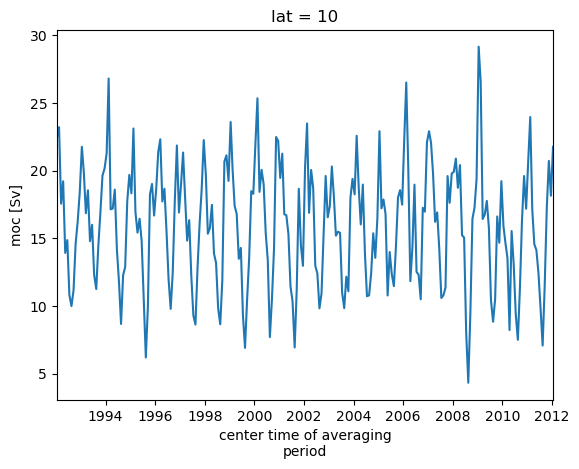

In [72]:
ds['moc'].sel(lat=10).plot()
plt.xlim(ds['moc']['time'][0],ds['moc']['time'][12*20])

# Find proxy for AMOC 

Text(0.5, 1.0, 'Upper 1km Mean Temperature Trend')

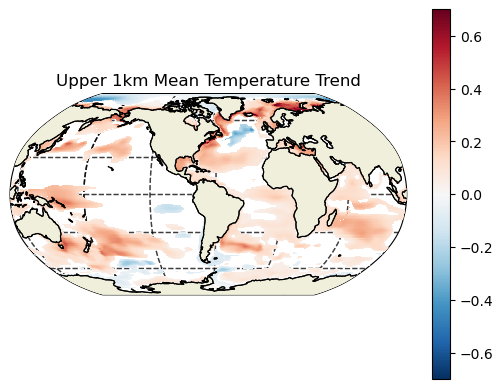

In [36]:
ds_theta_1km = xr.open_dataset('./data/ECCOv4r5_upper1000m_THETA_monthly.nc')
trd, p = delta(anu(ds_theta_1km['THETA']))

#fig, ax =  plt.subplots(1, 1, figsize=(6,4),)
ecco.plot_proj_to_latlon_grid(ds_theta_1km.XC, ds_theta_1km.YC, 
                              trd.where(p<0.1)*10, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.7, cmax=0.7, 
                              cmap='RdBu_r');
"""
ax.add_patch(patches.Rectangle((310, 45),30,15,edgecolor = 'royalblue',linestyle='-',linewidth=1,
                               fill=False,transform=ccrs.PlateCarree()))
ax.add_patch(patches.Rectangle((310, 15),30,15,edgecolor = 'crimson',linestyle='-',linewidth=1,
                               fill=False,transform=ccrs.PlateCarree()))
"""
plt.title('Upper 1km Mean Temperature Trend')
#plt.savefig('./plots/AMOC'+str(sel_lat)+'&Qnet_detrended_'+str(amoc_lead_yr)+'lag.png',dpi=1000)

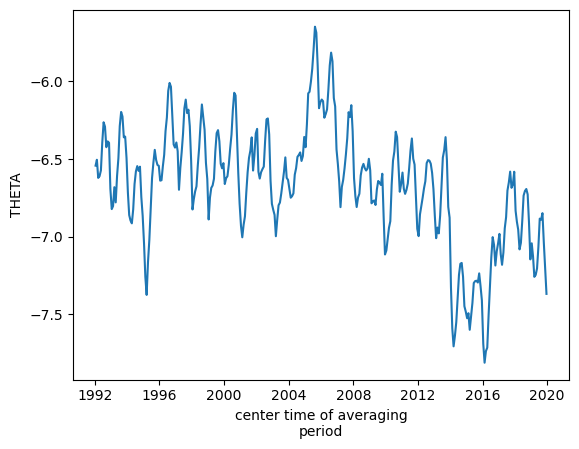

In [73]:
def meri_diff(var):
    box1_slat = 45
    box1_nlat = 55
    box1_wlon = -40
    box1_elon = -10
    
    box2_slat = 25
    box2_nlat = 35
    box2_wlon = -40
    box2_elon = -10
    
    var_box1 = var.where((var['XC']-box1_wlon)*(var['XC']-box1_elon)<=0).where((var['YC']-box1_nlat)*(var['YC']-box1_slat)<=0).mean(('tile','i','j'))
    var_box2 = var.where((var['XC']-box2_wlon)*(var['XC']-box2_elon)<=0).where((var['YC']-box2_nlat)*(var['YC']-box2_slat)<=0).mean(('tile','i','j'))
    return var_box1-var_box2

theta_meri_diff = meri_diff(ds_theta_1km['THETA'])
theta_meri_diff.plot()

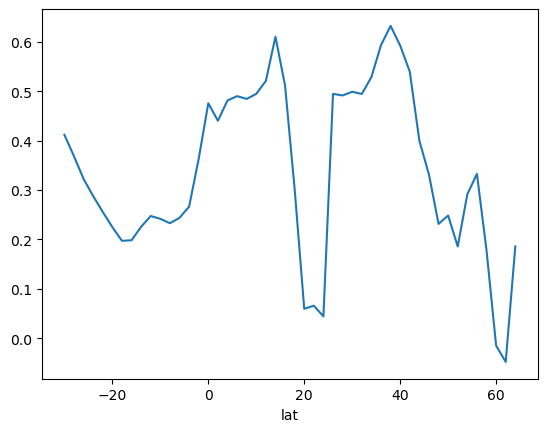

In [74]:
# Explained variance 
def normalize(var):
    return (var-var.mean('year'))/var.std('year')
test_r = xs.pearson_r(normalize(anu(ds['moc'])), normalize(anu(theta_meri_diff)), dim='year',skipna=True)
test_r.plot()

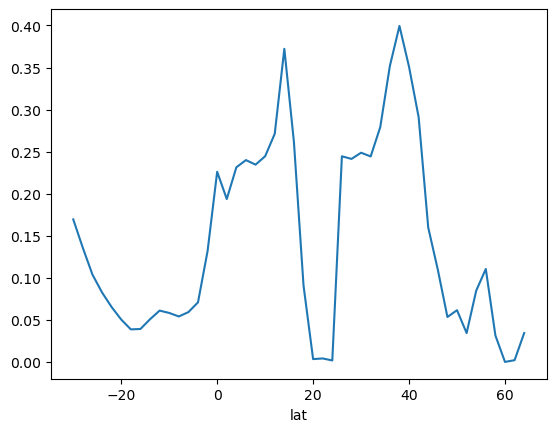

In [75]:
slope = xs.linslope(normalize(anu(ds['moc'])), normalize(anu(theta_meri_diff)), dim='year',skipna=True)
predict_diff = slope*normalize(anu(ds['moc']))
r2 = xs.r2(normalize(anu(theta_meri_diff)), predict_diff, dim='year',skipna=True)
r2.plot()

# Imprint (SST, ...) 

In [6]:
# load surface heat flux data
ds_q = xr.open_dataset('./data/ECCOv4r5_oceQnet_anu_mean.nc')
q_dt = detrend(ds_q['oceQnet'])

Text(0.5, 1.0, 'Correlation btw AMOC at 40N and Qnet')

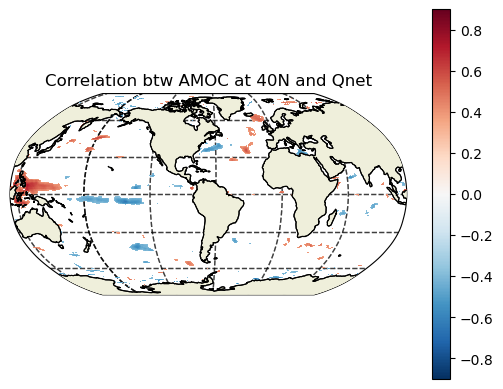

In [26]:
# Look at the correlation between AMOC at "sel_lat" and by "amoc_lead_yr" 
sel_lat = 40
amoc_lead_yr = -1
#sst_amoc_regr = xs.linslope(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), sst_dt, dim='year',skipna=True)
q_amoc_regr = xs.pearson_r(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), q_dt, dim='year',skipna=True)
q_amoc_regr_p = xs.pearson_r_p_value(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), q_dt, dim='year',skipna=True)

ecco.plot_proj_to_latlon_grid(ds_q.XC, ds_q.YC, 
                              q_amoc_regr.where(q_amoc_regr_p<0.05), 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');
plt.title('Correlation btw AMOC at '+str(sel_lat)+'N and Qnet')
#plt.savefig('./plots/AMOC'+str(sel_lat)+'&Qnet_detrended_'+str(amoc_lead_yr)+'lag.png',dpi=1000)

In [64]:
# load SST data 
ds_sst = xr.open_dataset('./data/ECCOv4r5_SST_anu_mean.nc')
sst_trd, sst_trd_p = delta(ds_sst['THETA'])
sst_dt = detrend(ds_sst['THETA'])

Text(0.5, 1.0, 'Correlation btw AMOC at 50N and SST')

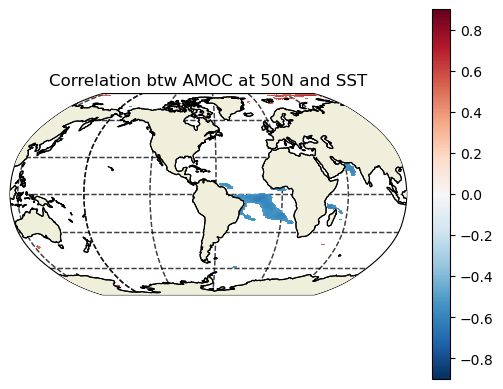

In [107]:
# Look at the correlation between AMOC at "sel_lat" and by "amoc_lead_yr" 
sel_lat = 50
amoc_lead_yr = -4
#sst_amoc_regr = xs.linslope(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), sst_dt, dim='year',skipna=True)
sst_amoc_regr = xs.pearson_r(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), sst_dt, dim='year',skipna=True)
sst_amoc_regr_p = xs.pearson_r_p_value(moc_anu_dt.sel(lat=sel_lat).shift(year=amoc_lead_yr), sst_dt, dim='year',skipna=True)

ecco.plot_proj_to_latlon_grid(ds_sst.XC, ds_sst.YC, 
                              sst_amoc_regr.where(sst_amoc_regr_p<0.01), 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');
plt.title('Correlation btw AMOC at '+str(sel_lat)+'N and SST')
#plt.savefig('./plots/AMOC'+str(sel_lat)+'&SST_detrended_'+str(amoc_lead_yr)+'lag.png',dpi=1000)

In [65]:
sst_trd

<xarray.DataArray (tile: 13, j: 90, i: 90)> Size: 842kB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-2.19417249e-03, -2.08385269e-03, -1.43230138e-03, ...,
         -2.85844164e-03, -1.57334439e-03, -8.68426837e-04],
        [-8.08163539e-04, -4.14386473e-04,  3.77000259e-04, ...,
         -1.63641475e-03,  9.76432272e-05,  1.29248490e-03],
        [-1.57206421e-03, -7.73136659e-04,  3.01472015e-04, ...,
         -5.18216190e-04,  1.48406925e-03,  3.04659352e-03]],

       [[-3.43444616e-03, -2.12079916e-03, -6.11458196e-04, ...,
          1.87819309e-05,  2.19425071e-03,  3.96995384e-03],
        [-4.22659678e-03, -2.26246076e-03, -5.56258325e-04, ...,
          2.96064867e-05,  2.21835447e-03,  3.98939910e-03],
        [-3.11885361e-03, -1.04602860e-03,  3.48444121e-04, ...,
         -2.42475667e-04,  1.72529311e-03,  3.32598776e-03],
...
        [ 1.04666294e-02,  9.94894396e-03,  9.36680748e-03, ...,
         -8.95748506e-03, -8.81098606e-03, -7.04535419e-03],
        [ 1.09118554e-02,  1.03367658e-02,  9.60255191e-03, ...,
         -7.28651971e-03, -7.43027425e-03, -5.61134288e-03],
        [ 1.11410765e-02,  1.06159533e-02,  9.82253383e-03, ...,
         -5.35708331e-03, -5.90587988e-03, -4.51186800e-03]],

       [[-1.89750957e-02, -1.44432356e-02, -1.03161694e-02, ...,
                     nan,             nan,             nan],
        [-1.68901967e-02, -1.35201463e-02, -1.07613208e-02, ...,
                     nan,             nan,             nan],
        [-1.55822605e-02, -1.32448046e-02, -1.16625821e-02, ...,
                     nan,             nan,             nan],
        ...,
        [-4.73396814e-03, -2.83844632e-03, -2.65402565e-03, ...,
                     nan,             nan,             nan],
        [-3.03211048e-03, -1.34107491e-03, -1.84151898e-03, ...,
                     nan,             nan,             nan],
        [-2.13538668e-03, -9.14477640e-04, -1.89793708e-03, ...,
                     nan,             nan,             nan]]])
Coordinates:
    k        int32 4B 0
    Z        float32 4B -5.0
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    XC       (tile, j, i) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...

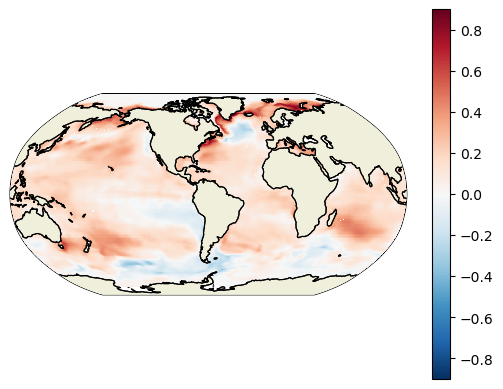

In [70]:
ecco.plot_proj_to_latlon_grid(ds_sst.XC, ds_sst.YC, 
                              sst_trd*10, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');

In [4]:
# windstress field
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))
dataset_num = 1

wind_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]
wind_dataset_files = np.sort(list(wind_dataset_dir.glob('*nc'))) #[:12]

ecco_vars_tau = xr.open_mfdataset(wind_dataset_files, 
                                  parallel=True, data_vars='minimal',\
                                  coords='minimal',compat='override',
                                  combine='nested', concat_dim='time',
                                  chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
ecco_vars_tau

<xarray.Dataset> Size: 854MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2,
                nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    EXFatemp   (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    EXFaqh     (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    EXFpress   (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    EXFuwind   (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    EXFvwind   (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    EXFwspee   (time, tile, j, i) float32 142MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         152e19ea-2713-11f0-983f-0a58a9feac02

In [8]:
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

uwind,vwind = ecco.vector_calc.UEVNfromUXVY(ecco_vars_tau['EXFuwind'],ecco_vars_tau['EXFvwind'],ds_geom )
uwind_DJF_mean = uwind.groupby('time.season').mean('time').sel(season='DJF').compute()
vwind_DJF_mean = vwind.groupby('time.season').mean('time').sel(season='DJF').compute()

In [11]:
uwind_2010 = uwind[215:218,:,:,:].mean('time').compute()
vwind_2010 = vwind[215:218,:,:,:].mean('time').compute()

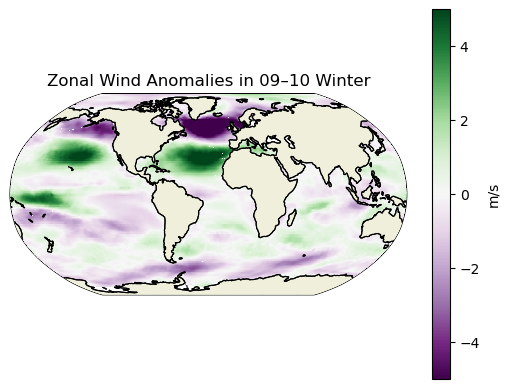

In [18]:
ecco.plot_proj_to_latlon_grid(uwind_DJF_mean.XC, uwind_DJF_mean.YC, 
                              uwind_2010-uwind_DJF_mean, 
                              user_lon_0=-30, show_colorbar=True,
                              colorbar_label='m/s', 
                              cmin=-5, cmax=5, 
                              cmap='PRGn');
plt.title('Zonal Wind Anomalies in 09–10 Winter')
plt.savefig('./plots/UWind_Anomalies_09-10Winter.png',dpi=1000)

In [ ]:
var_name = 'EXFuwind'
data2plot_u_temp = ((ecco_vars_tau[var_name].groupby('time.year').mean('time') - ecco_vars_tau[var_name].mean('time')).isel(year=18)).compute()
var_name = 'EXFvwind'
data2plot_v_temp = ((ecco_vars_tau[var_name].groupby('time.year').mean('time') - ecco_vars_tau[var_name].mean('time')).isel(year=18)).compute()

Text(0.5, 1.0, 'VWind Stress Anomalies in 2010')

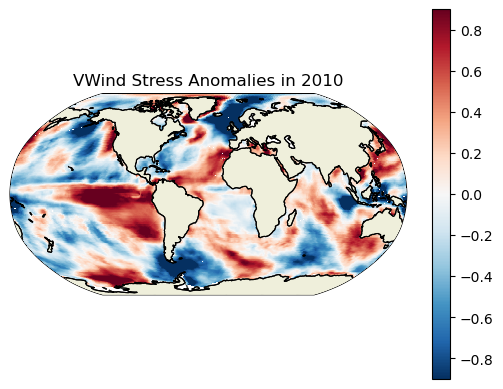

In [30]:
ecco.plot_proj_to_latlon_grid(vwind_mean.XC, vwind_mean.YC, 
                              vwind_2010-vwind_mean, 
                              user_lon_0=-30, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');
plt.title('VWind Stress Anomalies in 2010')

Text(0.5, 1.0, 'UWind Stress Anomalies in 2010')

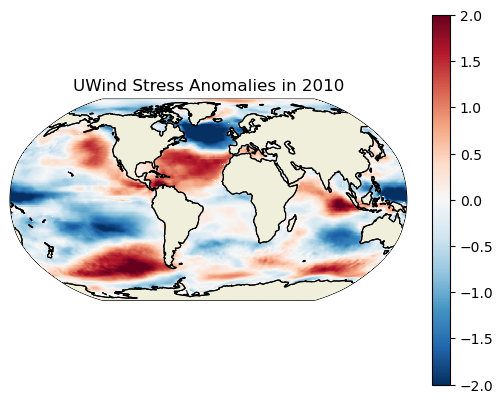

In [32]:
ecco.plot_proj_to_latlon_grid(uwind_mean.XC, uwind_mean.YC, 
                              uwind_2010-uwind_mean, 
                              user_lon_0=-30, show_colorbar=True,
                              color_bar
                              cmin=-2, cmax=2, 
                              cmap='RdBu_r');
plt.title('UWind Stress Anomalies in 2010')

Text(0.5, 1.0, 'VWind Stress Anomalies in 2010')

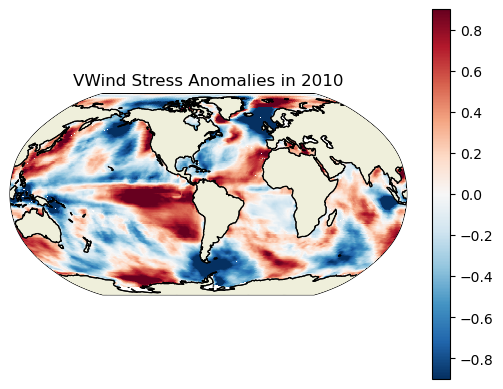

In [33]:
data2plot_u = data2plot_u_temp.copy()
data2plot_v = data2plot_v_temp.copy()
data2plot_u[6:,:,:] = data2plot_v_temp[6:,:,:]
data2plot_v[6:,:,:] = -data2plot_u_temp[6:,:,:]

ecco.plot_proj_to_latlon_grid(data2plot_v.XC, data2plot_v.YC, 
                              data2plot_v, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');
plt.title('VWind Stress Anomalies in 2010')

Text(0.5, 1.0, 'UWind Stress Anomalies in 2010')

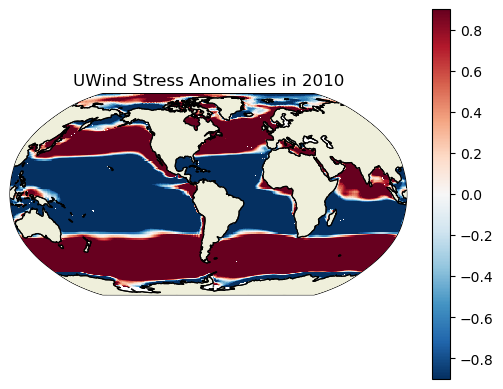

In [26]:
ecco.plot_proj_to_latlon_grid(uwind.XC, uwind.YC, 
                              uwind.mean('time'), 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-0.9, cmax=0.9, 
                              cmap='RdBu_r');
plt.title('UWind Stress Anomalies in 2010')

# Meridional coherence


In [100]:
MHT[sel_lat]

<xarray.DataArray 'MHT' (time: 336)> Size: 3kB
[336 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Attributes:
    units:    PW